## Import

In [1]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from time import perf_counter
import matplotlib.pyplot as plt
import torch
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/wizard/mlops/MLOps_course_AGH/lab7/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/articles.csv")

In [27]:
model_name = "sentence-transformers/multi-qa-mpnet-base-cos-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

sample_text = df["text"].iloc[0]

inputs = tokenizer(sample_text, padding=True, truncation=True, return_tensors="pt")

In [4]:
inputs["input_ids"].shape

torch.Size([1, 512])

## Evaluation mode

In [32]:
def measure_time(model, inputs, device=None, runs=100, context=None, label=""):
    if device is not None:
        model = model.to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}
    # warm-up
    for _ in range(5):
        model(**inputs)

    start = perf_counter()

    if context is None:
        for _ in range(runs):
            model(**inputs)
    else:
        with context:
            for _ in range(runs):
                model(**inputs)

    end = perf_counter()

    avg = (end - start) / runs
    print(f"{label}: {avg:.4f} sec/run")
    return avg

In [6]:
labels = [
    "No optimizations (PyTorch)",
    "model.eval() only",
    "model.eval() + no_grad()",
    "model.eval() + inference_mode()",
]

config_cpu = {"device": "cpu", "runs": 20}
config_gpu = {"device": "cuda:0", "runs": 100}

In [ ]:
model.train()
simple_pytorch_time = measure_time(model, inputs, **config_cpu, label=labels[0])

model.eval()
model_eval = measure_time(model, inputs, **config_cpu, label=labels[1])

model.eval()
no_grad_time = measure_time(
    model, inputs, context=torch.no_grad(), **config_cpu, label=labels[2]
)

model.eval()
inference_time = measure_time(
    model, inputs, context=torch.inference_mode(), **config_cpu, label=labels[3]
)

outputs_cpu = (
    np.array([simple_pytorch_time, model_eval, no_grad_time, inference_time])
    / simple_pytorch_time
)

No optimizations (PyTorch): 0.9740 sec/run
model.eval() only: 0.7854 sec/run
model.eval() + no_grad(): 0.8203 sec/run
model.eval() + inference_mode(): 0.8374 sec/run


In [11]:
model.train()
simple_pytorch_time = measure_time(model, inputs, **config_gpu, label=labels[0])

model.eval()
model_eval = measure_time(model, inputs, **config_gpu, label=labels[1])

model.eval()
no_grad_time = measure_time(
    model, inputs, context=torch.no_grad(), **config_gpu, label=labels[2]
)

model.eval()
inference_time = measure_time(
    model, inputs, context=torch.inference_mode(), **config_gpu, label=labels[3]
)

outputs_gpu = (
    np.array([simple_pytorch_time, model_eval, no_grad_time, inference_time])
    / simple_pytorch_time
)

No optimizations (PyTorch): 0.0456 sec/run
model.eval() only: 0.0436 sec/run
model.eval() + no_grad(): 0.0435 sec/run
model.eval() + inference_mode(): 0.0432 sec/run


([<matplotlib.axis.XTick at 0x7b6ca0d1b6e0>,
 [Text(0, 0, 'No optimizations (PyTorch)'),
  Text(1, 0, 'model.eval() only'),
  Text(2, 0, 'model.eval() + no_grad()'),
  Text(3, 0, 'model.eval() + inference_mode()')])

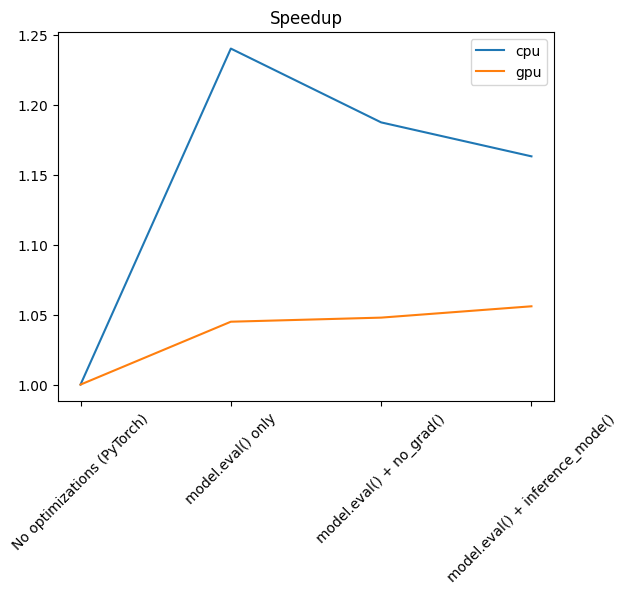

In [12]:
plt.plot(1 / outputs_cpu, label="cpu")
plt.plot(1 / outputs_gpu, label="gpu")
plt.title("Speedup")
plt.legend()
plt.xticks(list(range(4)), labels=labels, rotation=45)

### comment
I believe the small change on gpu side might be caused by small model and input. In my experience the no_grad could cut the time in half, but here there is mere few percent of improvement (it can be caused as well as I've run it on my local laptop)

## Compilation

In [ ]:
model.eval()
model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
compiled_model = torch.compile(model)
torch.cuda.synchronize()
start = perf_counter()

with torch.inference_mode():
    output = compiled_model(**inputs)

torch.cuda.synchronize()
end = perf_counter()
compile_warmup_time = end - start
print(f"Compilation + warm-up time: {compile_warmup_time:.6f} sec")

Compilation + warm-up time: 22.914937 sec


In [18]:
with torch.inference_mode():
    start = perf_counter()
    for _ in range(100):
        compiled_model(**inputs)
    end = perf_counter()

compiled_time = (end - start) / 100

print(f"compiled model: {compiled_time:.4f} sec/run")
print(f"speedup: {simple_pytorch_time / compiled_time}")

compiled model: 0.0317 sec/run
speedup: 1.4405702001998026


### comment
Thats the best speedup so far

In [19]:
simple_pytorch_time

0.045609689699995216

## Quantization

In [ ]:
quantized_model = torch.ao.quantization.quantize_dynamic(
    model.to("cpu"), {torch.nn.Linear}, dtype=torch.qint8
)

In [22]:
model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [21]:
quantized_model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (k): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (v): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (o): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (dropout): Dropout(p=0.1, inplace=F

In [24]:
torch.save(model.state_dict(), "data/model.pt")
torch.save(quantized_model.state_dict(), "data/quantized_model.pt")

In [30]:
import os

print(f"normal model: {os.path.getsize('data/model.pt') / 2**20:.04f} MB")
print(f"quantized model: {os.path.getsize('data/quantized_model.pt') / 2**20:.04f} MB")

normal model: 417.7161 MB
quantized model: 173.0967 MB


In [31]:
inputs = {k: v.to("cpu") for k, v in inputs.items()}

In [34]:
normal_time = measure_time(
    model,
    inputs,
    context=torch.inference_mode(),
    device="cpu",
    runs=100,
    label="normal",
)
quantized_time = measure_time(
    quantized_model, inputs, context=torch.inference_mode(), runs=100, label="quantized"
)

normal: 0.7230 sec/run
quantized: 0.5575 sec/run


In [35]:
speedup = normal_time / quantized_time
print(f"{speedup=}")

speedup=1.2968696520260108


## GPU optimization

In [28]:
model.eval()
model = model.to("cuda:0")
inputs = {k: v.to("cuda:0") for k, v in inputs.items()}

In [6]:
def compilation_test(model, inputs, runs=100, **kwargs):
    compiled_model = torch.compile(model, **kwargs)
    torch.cuda.synchronize()
    start = perf_counter()

    with torch.inference_mode():
        compiled_model(**inputs)

    torch.cuda.synchronize()
    end = perf_counter()
    compile_warmup_time = end - start
    print(f"Compilation + warm-up time: {compile_warmup_time:.6f} sec")

    with torch.inference_mode():
        start = perf_counter()
        for _ in range(runs):
            compiled_model(**inputs)
        end = perf_counter()

    compiled_time = (end - start) / runs

    print(f"compiled model {kwargs}: {compiled_time:.4f} sec/run")
    return compiled_time

In [7]:
clean_compile = compilation_test(model, inputs)
max_autotune = compilation_test(model, inputs, mode="max-autotune")
no_cudagraphs = compilation_test(model, inputs, mode="max-autotune-no-cudagraphs")

Compilation + warm-up time: 8.593416 sec
compiled model {}: 0.0298 sec/run
Compilation + warm-up time: 5.934765 sec
compiled model {'mode': 'max-autotune'}: 0.0171 sec/run
Compilation + warm-up time: 5.495964 sec
compiled model {'mode': 'max-autotune-no-cudagraphs'}: 0.0313 sec/run


In [17]:
second_inputs = {k: v[:, : v.shape[1] // 4] for k, v in inputs.items()}

In [19]:
clean_compile = compilation_test(model, second_inputs)
max_autotune = compilation_test(model, second_inputs, mode="max-autotune")
no_cudagraphs = compilation_test(
    model, second_inputs, mode="max-autotune-no-cudagraphs"
)

Compilation + warm-up time: 23.944783 sec
compiled model {}: 0.0082 sec/run


W1124 17:55:36.654000 7740 torch/_inductor/utils.py:1048] [0/4] Not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(128x768, 128x768, 768x768)
  addmm 0.0843 ms 100.0% 
  bias_addmm 0.0927 ms 90.9% 
SingleProcess AUTOTUNE benchmarking takes 0.3019 seconds and 0.0001 seconds precompiling


Compilation + warm-up time: 24.756983 sec
compiled model {'mode': 'max-autotune'}: 0.0092 sec/run
Compilation + warm-up time: 21.186614 sec
compiled model {'mode': 'max-autotune-no-cudagraphs'}: 0.0087 sec/run


### comment
With smaller input it seems that the speedup is no longer here

## Numerical precision

In [20]:
capability = torch.cuda.get_device_capability()
print(f"CUDA device capability: {capability}")

# Tensor Cores are available on NVidia GPUs with CUDA >= 7 (e.g. Volta, Turing, Ampere, Hopper)
if capability >= (7, 0):
    print("Tensor Cores available: fast float16 supported.")
else:
    print("Tensor Cores not available: float16 may be slow or unsupported.")

CUDA device capability: (7, 5)
Tensor Cores available: fast float16 supported.


In [56]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [61]:
model_half = model.half()
inputs_half = {
    "input_ids": inputs["input_ids"],
    "attention_mask": inputs["attention_mask"].half(),
}

In [63]:
RUNS = 100

with torch.inference_mode():
    start = perf_counter()
    for _ in range(RUNS):
        model(**inputs)
    end = perf_counter()

f32_time = (end - start) / RUNS

with torch.inference_mode():
    start = perf_counter()
    for _ in range(RUNS):
        model_half(**inputs_half)
    end = perf_counter()

f16_time = (end - start) / RUNS

with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.float16):
    start = perf_counter()
    for _ in range(RUNS):
        model(**inputs)
    end = perf_counter()

auto_time = (end - start) / RUNS
f32_time, f16_time, auto_time

(0.1578914756999984, 0.15720620489999418, 0.15961497930000404)

### comment
speedup is marginable (at least in those settings)

## ONNX

In [68]:
import onnxruntime as ort
import numpy as np

# Put the model in eval mode and move to CPU
model_cpu = model.eval().cpu()

# Example input for tracking (for onnx export)
sample_input = tokenizer(
    "This is a sample input text for ONNX export.",
    padding=True,
    truncation=True,
    return_tensors="pt",
)

# Export to ONNX format
torch.onnx.export(
    model_cpu,
    (sample_input["input_ids"], sample_input["attention_mask"]),
    "model.onnx",
    opset_version=17,
    input_names=["input_ids", "attention_mask"],
    output_names=["output"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "output": {0: "batch_size"},
    },
)


# Prepare input data
sample_input_inference = tokenizer(
    "This is a sample input text for ONNX inference.",
    padding=True,
    truncation=True,
    return_tensors="np",
)

# Create input dictionary, in same format as during export
inputs_onnx = {
    "input_ids": sample_input_inference["input_ids"],
    "attention_mask": sample_input_inference["attention_mask"],
}

### Online

In [70]:
options_online = ort.SessionOptions()
options_online.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

start_session = perf_counter()
ort_session_online = ort.InferenceSession(
    "model.onnx", sess_options=options_online, providers=["CPUExecutionProvider"]
)
end_session = perf_counter()
print(f"ONLINE Session creation time: {end_session - start_session:.6f} sec")

# Warm-up
for _ in range(5):
    _ = ort_session_online.run(None, inputs_onnx)

start_inf = perf_counter()
for _ in range(RUNS):
    _ = ort_session_online.run(None, inputs_onnx)
end_inf = perf_counter()
print(f"ONLINE inference time: {(end_inf - start_inf) / RUNS:.6f} sec/run")

ONLINE Session creation time: 1.179695 sec
ONLINE inference time: 0.025488 sec/run


In [71]:
options_offline = ort.SessionOptions()
options_offline.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
options_offline.optimized_model_filepath = "model_optimized.onnx"

start_session_offline = perf_counter()
ort_session_offline = ort.InferenceSession(
    "model.onnx", sess_options=options_offline, providers=["CPUExecutionProvider"]
)
end_session_offline = perf_counter()
print(
    f"OFFLINE Session creation + optimization time: {end_session_offline - start_session_offline:.6f} sec"
)

# Warm-up
for _ in range(5):
    _ = ort_session_offline.run(None, inputs_onnx)

start_inf_offline = perf_counter()
for _ in range(RUNS):
    _ = ort_session_offline.run(None, inputs_onnx)
end_inf_offline = perf_counter()
print(
    f"OFFLINE Avg inference time: {(end_inf_offline - start_inf_offline) / RUNS:.6f} sec/run"
)

OFFLINE Session creation + optimization time: 2.171263 sec


2025-11-24 19:32:19.306327390 [W:onnxruntime:, inference_session.cc:2473 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


OFFLINE Avg inference time: 0.026154 sec/run


## Test of docker requests

In [3]:
import requests
import time

URLS = {
    "PyTorch": "http://localhost:8000/infer",
    "ONNX": "http://localhost:8001/infer",
}

TEXT = "This is a test sentence for benchmarking inference speed."

RUNS = 100

for name, url in URLS.items():
    # Warm-up
    for _ in range(5):
        requests.post(url, json={"text": TEXT})

    start = time.perf_counter()
    for _ in range(RUNS):
        requests.post(url, json={"text": TEXT})
    end = time.perf_counter()

    print(f"{name} avg inference time: {(end - start) / RUNS:.6f} sec")

PyTorch avg inference time: 0.038611 sec
ONNX avg inference time: 0.030928 sec
